### Riddler Classic - https://fivethirtyeight.com/features/can-you-beat-the-shell-game-quantum-style/

Having solved the shell game in this week’s Express, you are now ready to play the quantum shell game. Instead of a ball, you are now trying to capture an electron. Now, you’re not sure precisely where it is, but you know it’s somewhere on a two-dimensional surface. What’s more, you know that the probability distribution is a 2D Gaussian (or “normal”) distribution. More precisely, the probability the electron is a distance r units in any direction from some central point is proportional to exp(−r2/2).

You have four cylindrical cups, each of which has a radius of 1 unit. In this game, you want to place the cups over the surface to maximize the probability that the electron is in one of the cups.

How should you place the cups, and what is the probability you will catch the electron?

### Solution

#### Intuition:
The probability distribution falls off exponentially as you move away from the origin, so you want to get the 4 cups as close to the origin as possible.

One possible maximal arrangement would be cups centered on $(\pm 1, \pm 1)$, as well as all similar arrangements that are equivalent to a rotation of this arrangement about the origin. The problem with this placement is that it doesn't cover the most probable region, right around the origin.

A second possibility that addresses this issue would be a cup centered on the origin, with the other three cups somewhere around the first cup. The problem with this is that the probability falls off as $\exp(-r^{2})$ so the other 3 cups will be covering much less probability.

Perhaps there is a third configuration with circles slightly offset so that each one inhabits one quadrant of the plane near the origin in a "z"-like shape.

It's unclear to me as yet which factors win out, so I will calculate these two scenarios and perhaps try to automate covering the rest of the possible arrangements.

First, let's take a look at some visualizations of the 2D Gaussian.

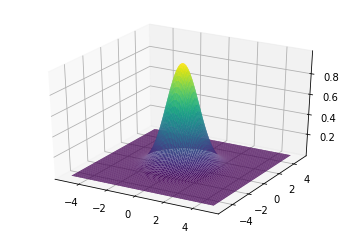

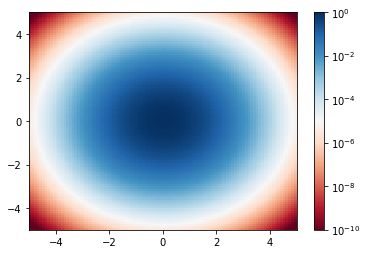

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.colors as colors

def gauss2D(x, y):
    return np.exp(-(x**2 + y**2)/2)

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)

X, Y = np.meshgrid(x, y)
Z = gauss2D(X, Y)

# 3d plot of 2D Gaussian z = exp(-r^2/2)
plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                cmap='viridis', edgecolor='none')
plt.show()

# heat map of 2D Gaussian z = exp(-r^2/2)
# log z scale shows how quickly the distribution falls off
def drawGauss2D():
    fig, ax = plt.subplots()
    c = ax.pcolormesh(X, Y, Z,
                  norm=colors.LogNorm(vmin=1, vmax=10**(-10)),
                  cmap='RdBu', shading='auto')
    fig.colorbar(c, ax=ax, ticks=[10**x for x in range(-10,2,2)])
    
drawGauss2D()
plt.show()

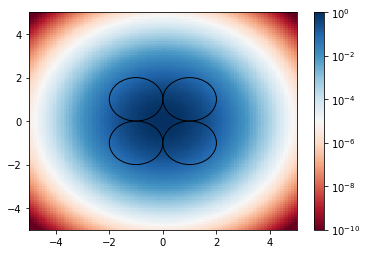

In [4]:
def drawCirclesAndGauss2D(origins, radius=1):
    fig, ax = plt.subplots()
    circles = []
    for i in range(len(origins)):
        circles.append(plt.Circle((origins[i][0], origins[i][1]), radius, color='k', fill=False, zorder=10))
        ax.add_patch(circles[i])
    c = ax.pcolormesh(X, Y, Z,
                  norm=colors.LogNorm(vmin=1, vmax=10**(-10)),
                  cmap='RdBu', shading='auto')
    fig.colorbar(c, ax=ax, ticks=[10**x for x in range(-10,2,2)])
    plt.show()
    
origins = [(1,1), (1,-1), (-1,1), (-1,-1)]
drawCirclesAndGauss2D(origins)

Now that we can see what the probability distribution looks like, we can tackle the problem of maximizing the probability under our 4 cups, here represented by the black circles.

We need to find the integral of the distribution within a circle centered on $(x_0, y_0)$. The circle can be written as $(x-x_0)^2 + (y-y_0)^2 = R^2 = 1$. This then gives us expressions for the upper and lower portions of the circle, which will be limits of the integration.

$$ (x-x_0)^2 + (y-y_0)^2 = 1 \\
    (y-y_0)^2 = 1 - (x-x_0)^2 \\
    y = \pm \sqrt{1 - (x-x_0)^2} + y_0 $$
    
The integral is then:

$$ \int_{x=x_0 - 1}^{x=x_0+1} \int_{y = - \sqrt{1 - (x-x_0)^2} + y_0}^{+ \sqrt{1 - (x-x_0)^2} + y_0}
        \exp(-(x^2 + y^2) / 2)\ dy \ dx $$
        
I will use the $\texttt{SciPy}$ library to evaluate the necessary double integrals.

In [5]:
from scipy.integrate import dblquad

@np.vectorize
def integrateCircleGauss2D(x0, y0, radius=1):
    f = lambda y,x: np.exp(-(x**2 + y**2)/2)
    area, err = dblquad(f, x0-radius, x0+radius, 
                        lambda x: -np.sqrt(1-(x-x0)**2)+y0, lambda x: np.sqrt(1-(x-x0)**2)+y0)
    return area

print(integrateCircleGauss2D(-1, 1))
print(integrateCircleGauss2D(0, 0))

1.1353089245271586
2.472240777719248


In [46]:
xx = np.linspace(-2.5, 2.5, 50)
yy = np.linspace(-2.5, 2.5, 50)
XX, YY = np.meshgrid(xx, yy)
integrals = integrateCircleGauss2D(XX, YY)
print(integrals)

[[0.01603123 0.0197313  0.02406728 ... 0.02406728 0.0197313  0.01603123]
 [0.0197313  0.02427584 0.02959905 ... 0.02959905 0.02427584 0.0197313 ]
 [0.02406728 0.02959905 0.03607576 ... 0.03607576 0.02959905 0.02406728]
 ...
 [0.02406728 0.02959905 0.03607576 ... 0.03607576 0.02959905 0.02406728]
 [0.0197313  0.02427584 0.02959905 ... 0.02959905 0.02427584 0.0197313 ]
 [0.01603123 0.0197313  0.02406728 ... 0.02406728 0.0197313  0.01603123]]


Now that the integral of a radius 1 circle has been calculated on the grid, we can find the combination of 4 circles that gives the most total area. First, we can test some of the proposed configurations.

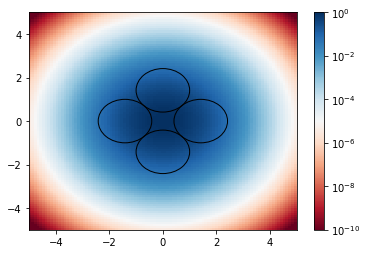

4.541235698108573


In [6]:
origins = [(np.sqrt(2),0), (0,np.sqrt(2)), (-np.sqrt(2),0), (0,-np.sqrt(2))]
drawCirclesAndGauss2D(origins)
totalArea = 0
for origin in origins:
    totalArea += integrateCircleGauss2D(origin[0], origin[1])
print(totalArea)

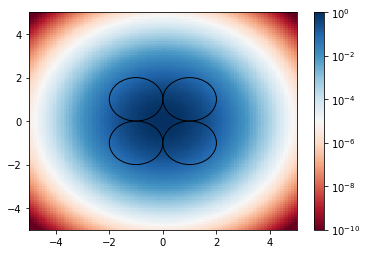

4.541235698108634


In [8]:
origins = [(1,1), (1,-1), (-1,1), (-1,-1)]
drawCirclesAndGauss2D(origins)
totalArea = 0
for origin in origins:
    totalArea += integrateCircleGauss2D(origin[0], origin[1])
print(totalArea)

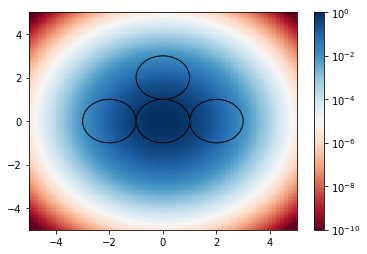

4.015874334547689


In [9]:
origins = [(0,0), (0,2), (-2,0), (2,0)]
drawCirclesAndGauss2D(origins)
totalArea = 0
for origin in origins:
    totalArea += integrateCircleGauss2D(origin[0], origin[1])
print(totalArea)

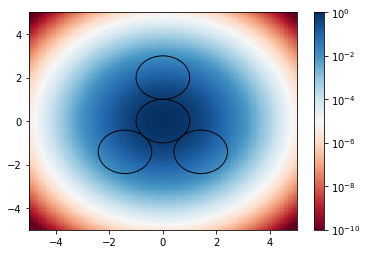

4.015874334547794


In [11]:
origins = [(0,0), (0,2), (-np.sqrt(2),-np.sqrt(2)), (np.sqrt(2),-np.sqrt(2))]
drawCirclesAndGauss2D(origins)
totalArea = 0
for origin in origins:
    totalArea += integrateCircleGauss2D(origin[0], origin[1])
print(totalArea)

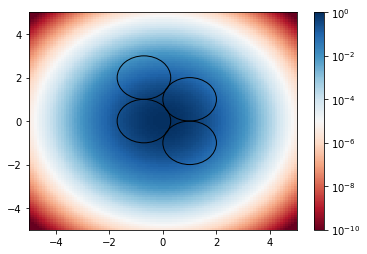

4.73000048150052
4.910509432662476
4.7852560244187545
4.356236487988098


In [12]:
origins = [(-np.sqrt(2)/2,2), (1,1), (-np.sqrt(2)/2,0), (1,-1)]
drawCirclesAndGauss2D(origins)
totalArea = 0
for origin in origins:
    totalArea += integrateCircleGauss2D(origin[0], origin[1])
print(totalArea)
totalArea = 0
for origin in origins:
    totalArea += integrateCircleGauss2D(origin[0], origin[1]-1/2)
print(totalArea)
totalArea = 0
for origin in origins:
    totalArea += integrateCircleGauss2D(origin[0], origin[1]-1)
print(totalArea)
totalArea = 0
for origin in origins:
    totalArea += integrateCircleGauss2D(origin[0], origin[1]-3/2)
print(totalArea)

Of the three possibilities I initally thought would be best, the configuration with origins at $\left[ \left(-\frac{\sqrt{2}}{2}, \frac{3}{2}\right), \left(1, \frac{1}{2}\right), \left(-\frac{\sqrt{2}}{2}, -\frac{1}{2}\right), \left(1, -\frac{3}{2}\right)\right]$ covers the largest portion of the probability distribution.

To check whether this is really the best of all possible configurations, we should loop over the possibilities and keep track of the largest area covered. While doing this, we must make sure that none of the circles overlap, since the cups cannot both cover the same space.

In [13]:
def checkNoOverlap(points, radius=1):
    for i in range(len(points)):
        for j in range(i+1, len(points)):
            x1, y1 = points[i]
            x2, y2 = points[j]
            dist = np.sqrt((x1-x2)**2 + (y1-y2)**2)
            if  dist < 2*radius:
                return False
    return True

print(checkNoOverlap([(-2,1),(0,0),(-1,1),(-1,-1)]))
print(checkNoOverlap([(-1,1),(-1,-1),(1,1),(1,-1)]))

False
True


One way to iterate over the possible configurations is to assume that the best configuration is going to be all the cups bordering each other. To try to cover the most area near the peak at the origin, the cups will have to be close, leaving as little space as possible, and trying to cover the large probability area. To try to cover all these possible configurations, the method is to start with one cup at some point, then place the other 3 cups around the outside of the first cup. These cups are placed at origins that can rotate around the origin of the central cup, so that their origins are 2 units apart and they just border each other. The following loops attempt to cover as many of the possible arrangements as possible.

In [183]:
xx = np.linspace(-2.5, 2.5, 101)
yy = np.linspace(-2.5, 2.5, 101)
XX, YY = np.meshgrid(xx, yy)
integrals = integrateCircleGauss2D(XX, YY)
points = list(it.product(range(len(xx)),range(len(xx))))

In [14]:
import itertools as it

def rotatePoint(point, alpha, axis=(0,0)):
    point = (point[0] - axis[0], point[1] - axis[1])
    return (point[0]*np.cos(alpha) - point[1]*np.sin(alpha) + axis[0],
           point[0]*np.sin(alpha) + point[1]*np.cos(alpha) + axis[1])

minAlpha = 1.05
maxAlpha = 2*np.pi - minAlpha

xx = np.linspace(-2.5, 2.5, 11)
yy = np.linspace(-2.5, 2.5, 11)
XX, YY = np.meshgrid(xx, yy)
points = list(it.product(range(len(xx)),range(len(xx))))

bestArea = 0
bestOrigins = []
for i in range(len(points)):
    if i%10==0: print(i, len(points))
    itr = points[i]
    point1 = ((XX[itr],YY[itr]))
    area1 = integrateCircleGauss2D(point1[0], point1[1])
    refPoint = (point1[0] + 2, point1[1])
    for alpha in np.arange(0, 2*np.pi - 3*minAlpha, 0.5):
        point2 = rotatePoint(refPoint, alpha, point1)
        if checkNoOverlap([point1, point2]) is False:
            continue
        area2 = integrateCircleGauss2D(point2[0], point2[1])
        for beta in np.arange(minAlpha, 2*np.pi - 2*minAlpha, 0.5):
            point3 = rotatePoint(point2, beta, point1)
            if checkNoOverlap([point1, point2, point3]) is False:
                continue
            area3 = integrateCircleGauss2D(point3[0], point3[1])
            for gamma in np.arange(minAlpha, 2*np.pi - minAlpha, 0.5):
                point4 = rotatePoint(point3, gamma, point1)
                if checkNoOverlap([point1, point2, point3, point4]) is False:
                    continue
                area4 = integrateCircleGauss2D(point4[0], point4[1])
                if (area1 + area2 + area3 + area4) > bestArea:
                    bestArea = area1 + area2 + area3 + area4
                    bestOrigins = [point1, point2, point3, point4]

print(bestArea, bestOrigins)

0 121
10 121
20 121
30 121
40 121
50 121
60 121
70 121
80 121
90 121
100 121
110 121
120 121
4.877592490613236 [(1.0, 0.0), (0.1677063269057152, 1.8185948536513634), (-0.9916166490781224, 0.1829292844648741), (-0.14964789306653792, -1.636554222128821)]


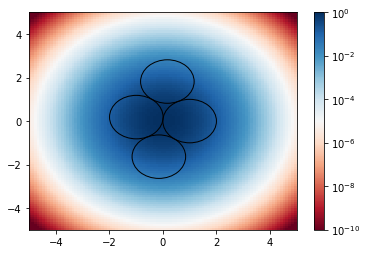

In [15]:
drawCirclesAndGauss2D(bestOrigins)

Because of the coarse iteration, this method doesn't actually return a better configuration that my trial and error. It's fairly close though, so it appears that the maximum area that can be covered is around 4.9.

This distribution was not normalized (we just know the probability is proportional to the distribution). To find what fraction of the total probability our configuration covers, we need to integrate the function over the entire plane. This can be done with a change of variables to polar coordinates.

$$
\int_{y=-\infty}^{y=\infty} \int_{x=-\infty}^{x=\infty} \exp(-(x^2+y^2)/2) \ dx \ dy 
= \int_{\theta=0}^{2\pi} \int_{r=0}^{\infty} \exp(-r^2/2) \ r dr \ d\theta \\
= 2\pi \left[\int_{r=0}^{\inf} \exp(-r^2/2) \ r dr\right] = 2\pi (0 - (-1)) \\
= 2\pi
$$

Since the total integral is $2\pi$ then our configuration with cups centered on $\left[ \left(-\frac{\sqrt{2}}{2}, \frac{3}{2}\right), \left(1, \frac{1}{2}\right), \left(-\frac{\sqrt{2}}{2}, -\frac{1}{2}\right), \left(1, -\frac{3}{2}\right)\right]$ has $\approx 78\%$ chance of covering the electron.
